# The code provided below is designed to demonstrate the data generated by the program pipeline

To begin with, the method _extract_required_metrics(report_path)_ is created that pulls all the necessary metrics from reports 
and creates a data frame and a convenient table based on them:

In [3]:
import pandas as pd
import os

# Function to extract required metrics from a report file
def extract_required_metrics(report_path):
    try:
        # Reading the report file
        df = pd.read_csv(report_path, sep='\t', header=None, names=['Metric', 'Value'])
        
        # Dictionary to store extracted metrics
        metrics = {}
        
        # List of key metrics to extract
        required_metrics = [
            ('Total length', 'Total length'),
            ('GC', 'GC (%)'),
            ('Largest contig', 'Largest Contig'),
            ('N50', 'N50'),
            ('N90', 'N90'),
            ('L50', 'L50'),
            ('L90', 'L90'),
            ('# N\'s per 100 kbp', '# N\'s per 100 kbp')
        ]
        
        # Extracting and saving the values of required metrics
        for metric_pattern, metric_name in required_metrics:
            metric_value = df[df['Metric'].str.contains(metric_pattern, case=False, regex=False)]['Value'].values
            if metric_value.size > 0:
                metrics[metric_name] = metric_value[0]
            else:
                metrics[metric_name] = 'N/A'  # Marking as 'N/A' if the metric is missing
        
        return metrics
    except Exception as e:
        print(f"Error processing {report_path}: {e}")
        return None

# Path to the directory containing report files
reports_dir = './reports'

# List of report files
report_files = [file for file in os.listdir(reports_dir) if file.endswith('.tsv')]

# Extracting and saving data from all report files
all_metrics_data = {}
for report_file in report_files:
    # Forming the full path to the report file
    report_path = os.path.join(reports_dir, report_file)
    # Determining the trimming parameter name from the report file name
    trimming_param = report_file.replace('report_scaffolds_', '').replace('.tsv', '')
    # Extracting metrics
    metrics = extract_required_metrics(report_path)
    if metrics:
        all_metrics_data[trimming_param] = metrics

# Converting the data into a DataFrame
all_metrics_df = pd.DataFrame.from_dict(all_metrics_data, orient='index').reset_index()
all_metrics_df.rename(columns={'index': 'Trimming Parameters'}, inplace=True)

# List of trimming parameters in the desired order
sorting_order = [
    "NoTrimming",
    "QualityTrim_Q25",
    "AdapterTrim_Q25",
    "LengthFilter_75",
    "ComplexityFilter",
    "SlidingWindow_4nt_q25",
    "QualitySlidingHybrid_Q25_4nt_q25", 
    "QualityAdapterHybrid_Q25", 
    "LengthComplexityHybrid_75", 
    "SlidingComplexityHybrid_4nt_q25",
    "AdapterSlidingHybrid_Q25_4nt_q25", 
    "QualityLengthHybrid_Q25_75", 
    "QualityComplexityHybrid_Q25", 
    "AdapterLengthHybrid_Q25_75", 
    "AdapterComplexityHybrid_Q25", 
    "LengthSlidingHybrid_75_4nt_Q25", 
]

# Sorting the DataFrame according to the specified order
sorted_metrics_df = all_metrics_df.set_index('Trimming Parameters').reindex(sorting_order).reset_index()

sorted_metrics_df


,Trimming Parameters,Total length,GC (%),Largest Contig,N50,N90,L50,L90,# N's per 100 kbp
0,NoTrimming,4404338,65.49,209132,74608,21687,18,57,9.20
1,QualityTrim_Q25,4347132,65.39,206803,64262,17217,20,68,7.43
2,AdapterTrim_Q25,4347132,65.39,206803,64262,17217,20,68,7.43
3,LengthFilter_75,4371727,65.42,209097,65136,17421,19,64,6.94
4,ComplexityFilter,4370526,65.41,209097,65136,17421,19,64,6.94
5,SlidingWindow_4nt_q25,4338271,65.45,173819,56417,16144,26,81,7.86
6,QualitySlidingHybrid_Q25_4nt_q25,4338271,65.45,173819,56417,16144,26,81,7.86
7,QualityAdapterHybrid_Q25,4347132,65.39,206803,64262,17217,20,68,7.43
8,LengthComplexityHybrid_75,4371727,65.42,209097,65136,17421,19,64,6.94
9,SlidingComplexityHybrid_4nt_q25,4338271,65.45,173819,56417,16144,26,81,7.86


## After that, we would like to visualize the same data, but in a more expressive way.

To do this, we first define the base values for the **"NoTrimming"** Trimming Parameters, assuming that this is the control group or standard condition to which all other values will be compared. 

Next, we'll deal with data normalization: we'll initialize an empty _rows_list_ to store the normalized rows. In a loop over each row of the original DataFrame, computes the normalized deviations for each metric compared to the base values of the **"NoTrimming"** Trimming Parameters. If the base value of a metric is 0, the normalized deviation is set to 0 to avoid division by zero. 

Next, a new DataFrame _norm_deviations_ is created from the _rows_list_ of dictionaries, where each dictionary is a row with normalized values.

### Data visualisation:

Using _seaborn.heatmap()_, we create a heatmap to visualize the normalized deviations of genome assembly metrics relative to the **"NoTrimming"** method.

In the heatmap, the rows correspond to the different trimming methods (Trimming Parameters) and the columns correspond to the genome assembly metrics.

The colors of the heatmap cells reflect the magnitude of the normalized deviations, centered at 0, where shades of red indicate positive deviation and shades of blue indicate negative deviation.

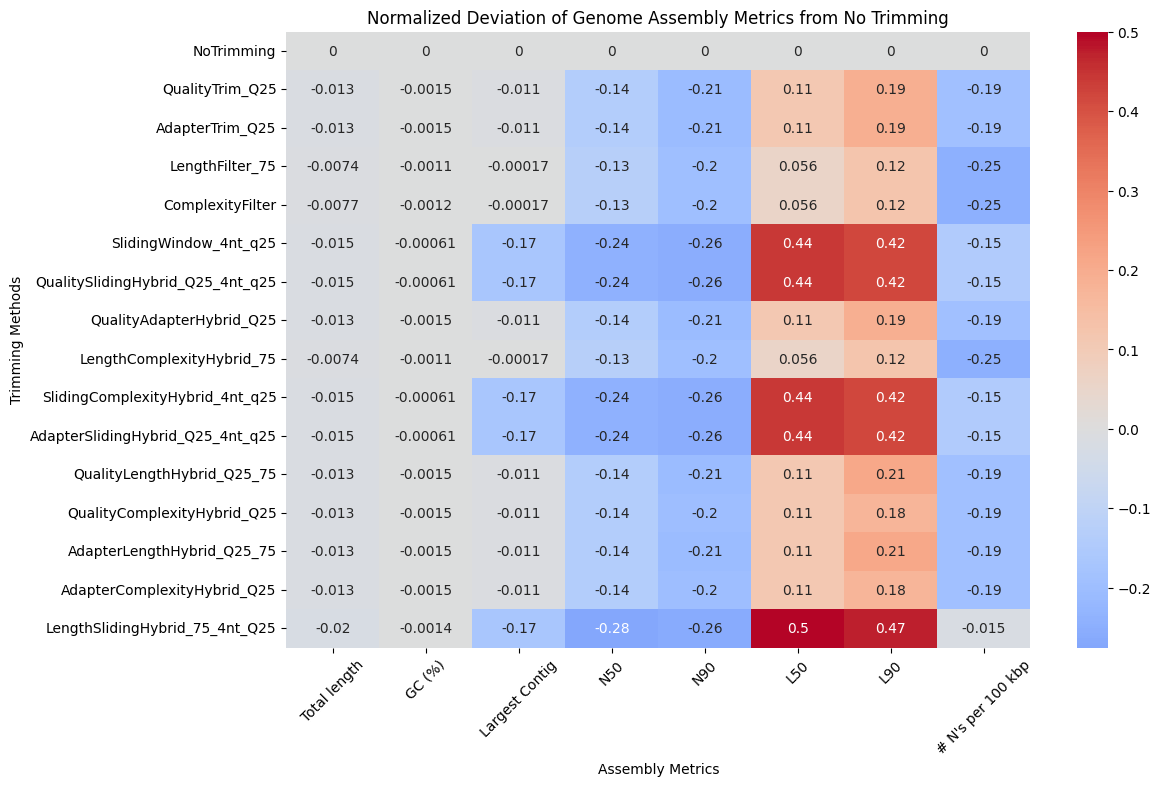

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data
# Make sure the data is numerical.
for column in sorted_metrics_df.columns[1:]:  # Skip the first column with the names of trimming methods
    sorted_metrics_df[column] = pd.to_numeric(sorted_metrics_df[column], errors='coerce')

# Find the base values for "NoTrimming"
base_values = sorted_metrics_df[sorted_metrics_df['Trimming Parameters'] == 'NoTrimming'].iloc[0, 1:]

# Initialization of the list for storing strings
rows_list = []

# Cycle to fill the list of rows
for index, row in sorted_metrics_df.iterrows():
    norm_row = {'Trimming Parameters': row['Trimming Parameters']}
    for metric in sorted_metrics_df.columns[1:]:
        if base_values[metric] != 0:
            norm_row[metric] = (row[metric] - base_values[metric]) / base_values[metric]
        else:
            norm_row[metric] = 0
    rows_list.append(norm_row)

# Creating a DataFrame from a list of strings
norm_deviations = pd.DataFrame(rows_list, columns=sorted_metrics_df.columns)

# Visualization of normalized deviations using a heat map
plt.figure(figsize=(12, 8))
sns.heatmap(norm_deviations.iloc[:, 1:], annot=True, cmap='coolwarm', center=0, yticklabels=norm_deviations['Trimming Parameters'])
plt.title('Normalized Deviation of Genome Assembly Metrics from No Trimming')
plt.xlabel('Assembly Metrics')
plt.ylabel('Trimming Methods')
plt.xticks(rotation=45)  # Rotate signatures for better readability
plt.show()
